# E08 - Kaggle

In [61]:
import warnings
warnings.filterwarnings('ignore')

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [62]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [63]:
# date컬럼의 값을 int로 처리, 데이터로 활용
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [64]:
# 타켓 데이터 처리
y = train['price']
del train['price']

In [65]:
# id 컬럼 삭제
del train['id']
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [66]:
# 테스트 데이터셋 전처리하기
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

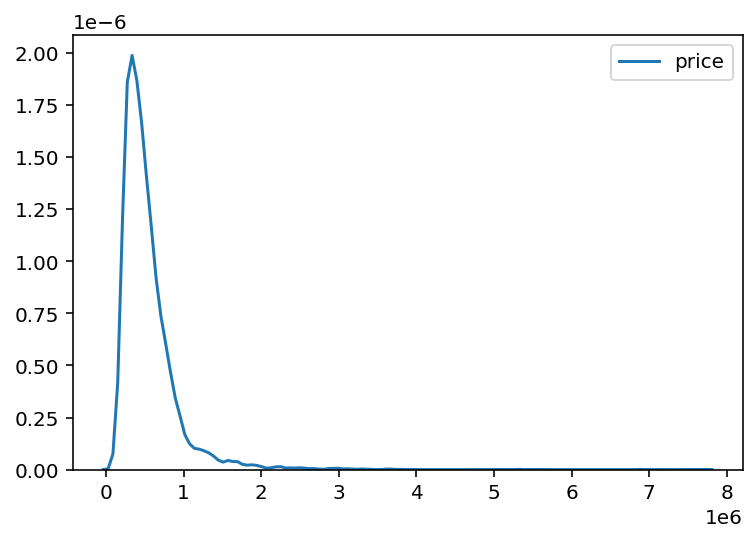

In [67]:
# y, price 데이터 전처리하기
sns.kdeplot(y)
plt.show()

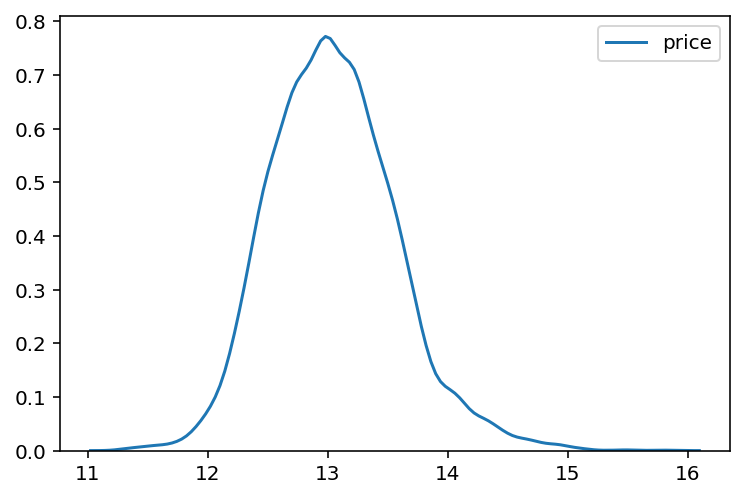

In [68]:
# price 데이터 로그 변환
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [80]:
# 다양한 실험을 진행하기 반복되는 작업은 함수로 만들기
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# RMSE 구하기, y데이터는 로그변환된 값이기 때문에 exp해준다.
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [130]:
# 최적의 하이퍼 파라미터 찾기
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

# GridSearchCV()의 인자
# param_grid: 탐색할 파라미터의 종류(딕셔너리 형태)
# scoring: 모델의 성능을 평가할 지표
# cv: cross validation을 진행하기 위해 train 데이터셋을 나누는 조각의 갯수
# verbose: 탐색 도중 진행 과정을 메시지로 출력
# n_jobs: 탐색 시 사용할 CPU의 갯수
# max_depth: 의사 결정 나무의 깊이, 정수 사용
# n_estimators: 사용하는 개별 모델의 갯수, 보통 50~100

# param_grid = {
#     'learning_rate': [0.05],
#     'n_estimators': [50, 1000],
#     'max_depth': [6],
#     'subsample': [0.9],
# }

param_grid = {
    'n_estimators': [100, 400],
    'max_depth':[1, 10]
}

model = LGBMRegressor(random_state=random_state)

# 그리드 탐색 후 결과 출력을 함수로 구현하기
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train, y)
    
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score']=score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results.sort_values('RMSLE')
    return results
    
my_GridSearch(model, train, y, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    1.3s finished


,max_depth,n_estimators,score,RMSLE
0,1,100,-0.055020,0.234564
1,1,400,-0.040215,0.200537
2,10,100,-0.027027,0.164399
3,10,400,-0.026121,0.161619


In [131]:
# 하이퍼 파라미터 입력하고 모델 학습시킨다.
models[2] = LGBMRegressor(max_depth=10, n_estimators=400, random_state=random_state)
models[1] = XGBRegressor(max_depth=6, n_estimators=1000, random_state=random_state)
# def AveragingBlending(models, train, y, test):
#     for m in models:
#         m.fit(train, y)
    
#     predictions = np.column_stack([
#         np.expm1(m.predict(test)) for m in models
#     ])
#     return np.mean(predictions, axis=1)

# prediction = AveragingBlending(models, train, y, test)
# prediction

# models[2].fit(train, y)
# models[1].fit(train, y)
# lgb_pred = models[2].predict(test)
# xgb_pred = models[1].predict(test)
# predictions = lgb_pred * 0.5 + xgb_pred * 0.5
# prediction = np.expm1(predictions)
# prediction

model.fit(train, y)
prediction = model.predict(test)
prediction = np.expm1(prediction)
prediction


array([ 498777.3643248 ,  475488.88022692, 1380314.506364  , ...,
        444939.4856097 ,  320269.39245244,  432724.14031526])

In [127]:
# submission만드는 함수 구현하기

def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved'.format(submission_csv_path))
    
save_submission(model, train, y, test, 'ensemble', rmsle='0.01596')

/home/aiffel0042/aiffel/kaggle_kakr_housing/data/submission_ensemble_RMSLE_0.01596.csv saved


Private Score : 110645.15159
n_estimators값 100에서 400으로 조정